In [2]:
import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
sys.path.append(SCRIPT_DIR)
import helper
from utils import data_utils
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
from torchvision import datasets
import analysis_utils
import numpy as np

/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
n_views = 100
batch_size = 8
model_dir = "../best_cifar10"

In [4]:
config = helper.Config(model_dir,default_config_file="../default_configs/default_config_cifar10.ini")
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  prune = prune_backbone,
                                  use_projection_head=config.SSL["use_projection_head"],
                                  proj_dim = config.SSL["proj_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  loss_name= config.SSL["loss_function"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = 1.0,
                                  scheduler_name = config.SSL["lr_scheduler"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"],
                                  pot_pow = config.SSL["pot_pow"])

Loading default settings...
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[INFO]
num_nodes = 1
gpus_per_node = 1
cpus_per_gpu = 1
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = auto
if_profile = False

[DATA]
dataset = CIFAR10
n_views = 16
n_trans = 1
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip']
augmentation_package = albumentations
crop_size = [32]
crop_min_scale = [0.08]
crop_max_scale = [1.0]
hflip_prob = [0.5]
blur_kernel_size = [3]
blur_prob = [0.5]
grayscale_prob = [0.2]
jitter_brightness = [0.8]
jitter_contrast = [0.8]
jitter_saturation = [0.8]
jitter_hue = [0.2]
jitter_prob = [0.8]

[SSL]
backbone = resnet18
use_projection_head = True
proj_dim = [2048]
proj_out_dim = 256
optimizer = LARS
lr = 2.0

In [5]:
data_dir = "../datasets/cifar10"
test_dataset = datasets.CIFAR10(root="../datasets/cifar10", train=False,download=False)
aug_ops = config.DATA["augmentations"] + ["ToTensor","Normalize"]
config.DATA["mean4norm"] = [0.491,0.482,0.446]
config.DATA["std4norm"] = [0.247,0.243,0.261]  

aug_ops = [[] for i in range(config.DATA["n_trans"])]
aug_params = [dict() for i in range(config.DATA["n_trans"])] 
for i in range(config.DATA["n_trans"]):
    aug_ops[i] = config.DATA["augmentations"] + ["ToTensor","Normalize"]
mean = [0.491,0.482,0.446]
std = [0.247,0.243,0.261]
test_dataset = datasets.CIFAR10(root=data_dir, train=False,download=True)

# get the transform 
transforms = []
for i in range(config.DATA["n_trans"]):
    for k in config.DATA:
        if isinstance(config.DATA[k],list) and k!= "augmentations":
            aug_params[i][k] = config.DATA[k][i]
        aug_params[i]["mean4norm"] = mean 
        aug_params[i]["std4norm"] = std
    transforms.append(data_utils.get_transform(aug_ops[i],aug_params=aug_params[i],aug_pkg="torchvision"))
test_dataset = data_utils.WrappedDataset(test_dataset,transforms,n_views = n_views,aug_pkg="torchvision")
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=False,drop_last=True,
                                            num_workers = 4)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 640x480 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

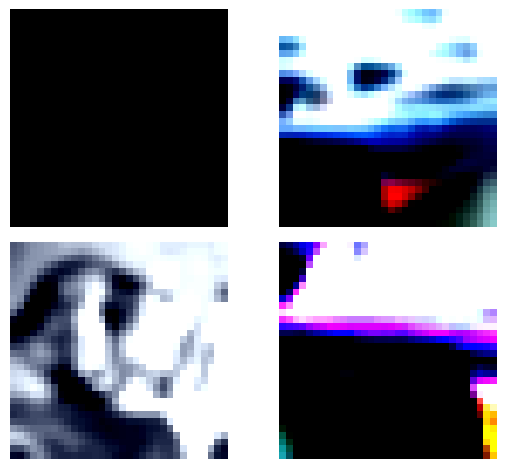

In [6]:
imgs,labels = next(iter(test_loader))

img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)


In [7]:
device = torch.device("cuda:0")  # Use GPU 0
trained_filename = os.path.join(model_dir,"ssl",'ssl-epoch=999.ckpt')
if os.path.isfile(trained_filename):
    print(f'Found pretrained model at {trained_filename}, loading...')
    ssl_model = lightning_models.CLAP.load_from_checkpoint(trained_filename)
ssl_model.backbone.remove_projection_head()
backbone = ssl_model.backbone.to(device)

Found pretrained model at ../best_cifar10/ssl/ssl-epoch=999.ckpt, loading...
max_mem_size is dummy for LogRepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for LogRepulsiveEllipsoidPackingLossUnitNorm


/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.4.0


In [8]:
def sample_submanifolds(backbone,test_loader,count=2400):
    center_vecs = []
    eigen_vecs = []
    all_labels = []
    traces = []
    i = 0
    for i,data in enumerate(test_loader):
        imgs,labels = data
        if i > count - 1:
            break
        all_labels.append(labels[0].detach().cpu())
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = backbone(imgs)
            preds = torch.reshape(preds,(n_views,batch_size,preds.shape[-1]))
            centers = torch.mean(preds,dim=0)
            preds -= centers
            cov = torch.matmul(torch.permute(preds,(1,2,0)), torch.permute(preds,(1,0,2)))/n_views # size B*O*O
            eigen = analysis_utils.power_iteration(cov)
            trace = torch.tensor(analysis_utils.get_cov_traces(cov),requires_grad=False)
            # save as CPU tensor to save GPU memory
            center_vecs.append(centers.detach().cpu())
            eigen_vecs.append(eigen.detach().cpu())
            traces.append(trace)
    center_vecs = torch.cat(center_vecs,dim=0)
    eigen_vecs = torch.cat(eigen_vecs,dim=0)
    traces = torch.cat(traces,dim=0)
    all_labels = torch.cat(all_labels,dim=-1)
    return center_vecs,eigen_vecs,traces,all_labels

In [9]:
center_vecs,eigen_vecs,traces,all_labels = sample_submanifolds(backbone,test_loader,count=20)

In [10]:
dist_matrix = analysis_utils.get_dist(center_vecs)
eigen_sim = analysis_utils.get_cosine_sim(eigen_vecs)
centroid_sim = analysis_utils.get_cosine_sim(center_vecs,rm_mean=True)

In [11]:
def inner_pairs(indices):
    print(len(indices))
    unique_pairs = [[indices[i], indices[j]] for i in range(len(indices)) for j in range(i+1, len(indices))]
    return np.array(unique_pairs)

In [12]:
def cross_pairs(ind1,ind2):
    pairs = [[ind1[i], ind2[j]] for i in range(len(ind1)) for j in range(len(ind2))]
    return np.array(pairs)

In [13]:
inner_dist = []
inter_dist = []
inner_sim = []
inter_sim = []
inner_center_sim = []
inter_center_sim = []


In [14]:
for repeat in range(10):
    center_vecs,eigen_vecs,traces,all_labels = sample_submanifolds(backbone,test_loader,count=100)
    dist_matrix = analysis_utils.get_dist(center_vecs)
    eigen_sim = analysis_utils.get_cosine_sim(eigen_vecs)
    centroid_sim = analysis_utils.get_cosine_sim(center_vecs,rm_mean=True)
    class_indices = [np.where(all_labels==i)[0] for i in range(9)]
    for indices in class_indices:
        pair = inner_pairs(indices)
        inner_dist.append(dist_matrix[pair[:,0],pair[:,1]])
        inner_sim.append(eigen_sim[pair[:,0],pair[:,1]])
        inner_center_sim.append(centroid_sim[pair[:,0],pair[:,1]])
    for i in range(len(class_indices)):
        for j in range(len(class_indices)):
            pair = cross_pairs(class_indices[i],class_indices[j])
            inter_dist.append(dist_matrix[pair[:,0],pair[:,1]])
            inter_sim.append(eigen_sim[pair[:,0],pair[:,1]])
            inter_center_sim.append(centroid_sim[pair[:,0],pair[:,1]])


80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84


In [15]:

inner_dist = np.concatenate(inner_dist,axis=0)
inter_dist = np.concatenate(inter_dist,axis=0)
# remove self distance
inner_dist = inner_dist[np.where(inner_dist>1e-6)]
inter_dist = inter_dist[np.where(inter_dist>1e-6)]

inner_sim = np.concatenate(inner_sim,axis=0)
inter_sim = np.concatenate(inter_sim,axis=0)
# remove self similarity
inner_sim = inner_sim[np.where(inner_sim < 1-1e-6)]
inter_sim = inter_sim[np.where(inter_sim < 1-1e-6)]
# remove self similarity
inner_center_sim = np.concatenate(inner_center_sim,axis=0)
inter_center_sim = np.concatenate(inter_center_sim,axis=0)
inner_center_sim = inner_center_sim[np.where(inner_center_sim < 1-1e-6)]
inter_center_sim = inter_center_sim[np.where(inter_center_sim < 1-1e-6)]

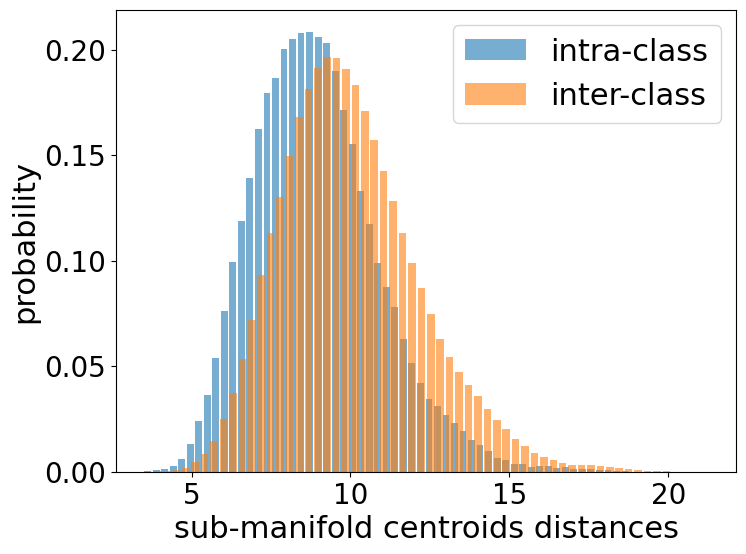

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes(111)
ax.hist(inner_dist, bins=60, density=True, rwidth=0.8,alpha=0.6,label="intra-class")
ax.hist(inter_dist, bins=60, density=True, rwidth=0.8,alpha=0.6,label="inter-class")
ax.legend(fontsize=22)
ax.set_xlabel("sub-manifold centroids distances",fontsize=22)
ax.set_ylabel("probability",fontsize=22)
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./centroid_distance.jpg",dpi=600,bbox_inches='tight')

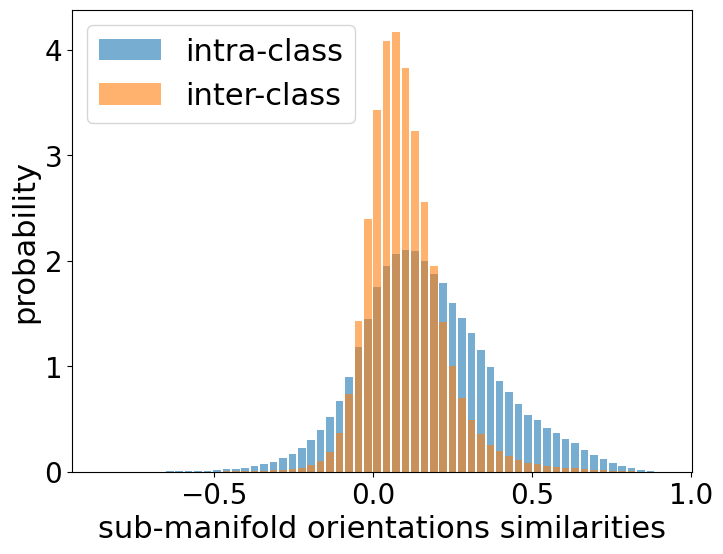

In [26]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes(111)
ax.hist(inner_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="intra-class")
ax.hist(inter_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="inter-class")
ax.legend(fontsize=22)
ax.set_xlabel("sub-manifold orientations similarities",fontsize=22)
ax.set_ylabel("probability",fontsize=22)
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./orientaion_similarity.jpg",dpi=600,bbox_inches='tight')

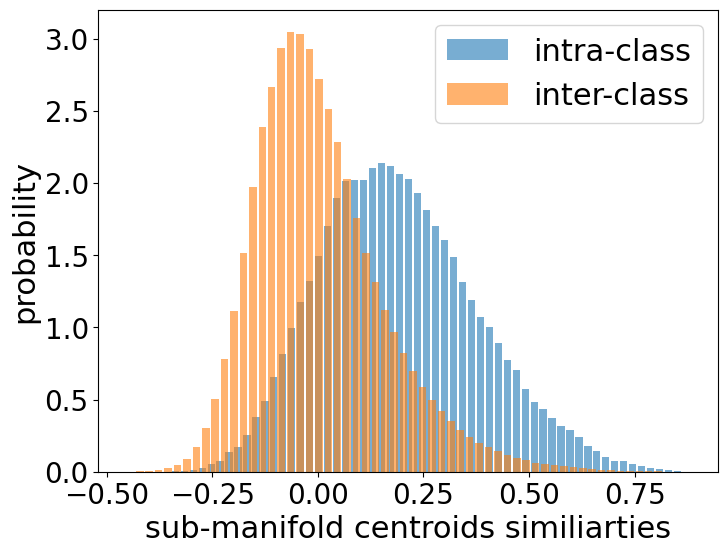

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes(111)
ax.hist(inner_center_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="intra-class")
ax.hist(inter_center_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="inter-class")
ax.set_xlabel("sub-manifold centroids similiarties",fontsize=22)
ax.set_ylabel("probability",fontsize=22)
ax.legend(fontsize=22)
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./centroid_similarity.jpg",dpi=600,bbox_inches='tight')

In [70]:
np.where(all_labels==2)[0]

array([  0,  12,  24,  26,  50,  75,  85,  99, 111, 113, 131, 158, 187,
       190, 192, 196])

In [39]:
test_dataset = datasets.CIFAR10(root="../datasets/cifar10", train=False,download=False)
aug_ops = ["ToTensor","Normalize"]
config.DATA["mean4norm"] = [0.491,0.482,0.446]
config.DATA["std4norm"] = [0.247,0.243,0.261]  
transform = data_utils.get_transform(aug_ops,aug_params=config.DATA,aug_pkg="torchvision")
test_dataset = data_utils.WrappedDataset(test_dataset,[transform],n_views = 2,aug_pkg="torchvision")
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)

In [44]:
def sample_manifolds(backbone,test_dataset,count=100):
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)
    class_center_vecs = []
    class_eigen_vecs = []
    class_traces = []
    class_reps = [[] for i in range(10)]
    class_rep_vecs = []
    for i,data in enumerate(test_loader):
        imgs,labels = data
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = backbone(imgs)
            preds = torch.reshape(preds,(2,batch_size,preds.shape[-1])).detach().cpu()
            #print(labels[0][0])
            for v in range(2):
                for b in range(batch_size):
                    class_reps[labels[v][b]].append(preds[v,b,:])
    print(class_reps)
    for i in range(len(class_reps)):
        rep_vecs = torch.cat(class_reps[i],dim=0)
        centers = torch.mean(rep_vecs,dim=0)
        rep_vecs -= centers
        print(rep_vecs.shape)
        cov = torch.matmul(torch.permute(rep_vecs,(1,2,0)), torch.permute(rep_vecs,(1,0,2)))/n_views # size B*O*O
        eigen = analysis_utils.power_iteration(cov)
        trace = torch.tensor(analysis_utils.get_cov_traces(cov),requires_grad=False)
        # save as CPU tensor to save GPU memory
        class_center_vecs.append(centers.detach().cpu())
        class_eigen_vecs.append(eigen.detach().cpu())
        class_traces.append(trace)
    class_center_vecs = torch.cat(class_center_vecs,dim=0)
    class_eigen_vecs = torch.cat(class_eigen_vecs,dim=0)
    class_traces = torch.cat(class_traces,dim=0)
    return class_center_vecs,class_eigen_vecs,class_traces

In [ ]:
n_views = 4
batch_size = 8
model_dir = "../simulations"
center_vecs,eigen_vecs,traces = sample_manifolds(backbone,test_dataset,count=4)